In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv
/kaggle/input/real-estate-price-prediction-moscow/train.csv
/kaggle/input/real-estate-price-prediction-moscow/test.csv


# Подключаем библиотеки и скрипты

In [2]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
matplotlib.rcParams.update({'font.size': 14})

In [5]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

# Подгружаем датасет

In [6]:
TRAIN_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [8]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [9]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [10]:
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [11]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [12]:
train_df.shape[1] - 1 == test_df.shape[1]

True

# Просмотр и изучение данных

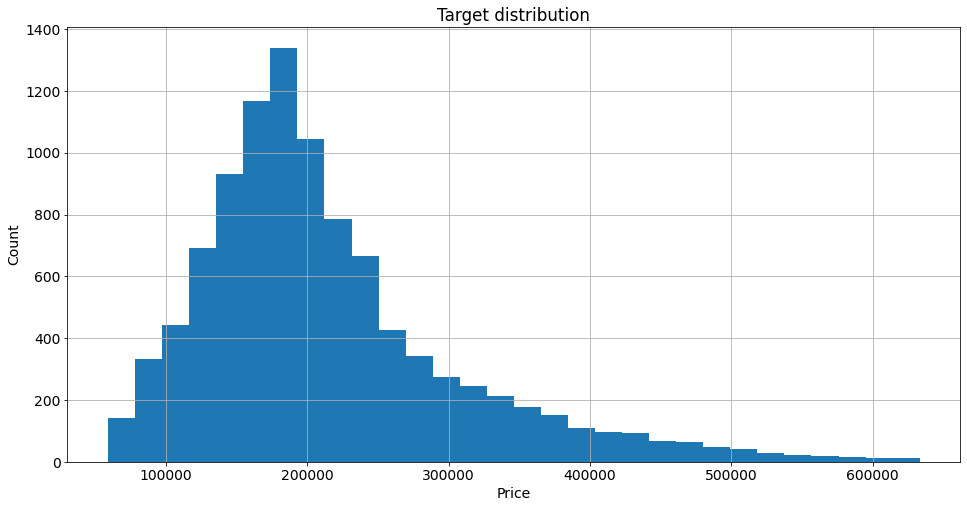

In [13]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

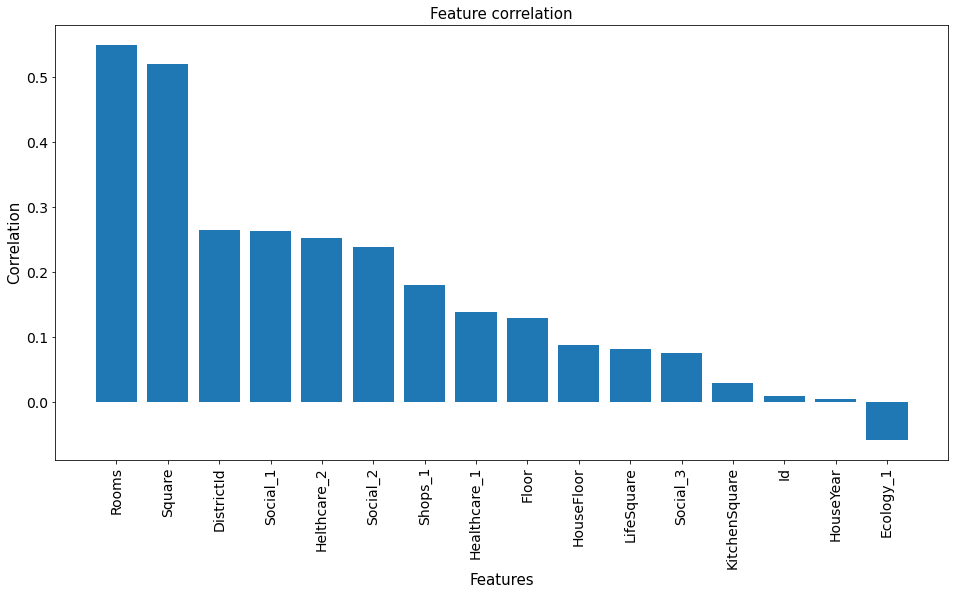

In [14]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

In [15]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [16]:
train_df.select_dtypes(include='object').columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

In [17]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
196      1
117      1
205      1
199      1
207      1
Name: DistrictId, Length: 205, dtype: int64

In [18]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [19]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [20]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

# Обработка выбросов

### Rooms

In [21]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [22]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [23]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = 5

In [24]:
train_df['Rooms'].value_counts()

2.0    3880
1.0    3713
3.0    2235
4.0     150
5.0      22
Name: Rooms, dtype: int64

In [25]:
train_df['Square'].value_counts()

52.327165    1
34.785487    1
45.823093    1
57.607965    1
57.925603    1
            ..
60.776683    1
72.956943    1
51.770111    1
41.843220    1
64.226361    1
Name: Square, Length: 10000, dtype: int64

In [26]:
train_df['LifeSquare'].value_counts()

20.151696    1
28.241964    1
23.884805    1
51.826876    1
47.972602    1
            ..
45.455722    1
50.458505    1
42.172028    1
21.993610    1
27.598712    1
Name: LifeSquare, Length: 7887, dtype: int64

### Square, LifeSquare

In [27]:
(train_df['Square'] < train_df['LifeSquare']).value_counts()

False    9518
True      482
dtype: int64

In [28]:
train_df['Square'], train_df['LifeSquare'] = np.where(train_df['Square'] < train_df['LifeSquare'],(train_df['LifeSquare'],train_df['Square']), (train_df['Square'],train_df['LifeSquare']))

In [29]:
(train_df['Square'] < train_df['LifeSquare']).value_counts()

False    10000
dtype: int64

### KitchenSquare

In [30]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2
32.0         2
41.0         2
43.0         2
30.0         2
25.0         2
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
66.0         1
2014.0       1
31.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
62.0         1
75.0         1
Name: KitchenSquare, dtype: int64

In [31]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [32]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [33]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

### HouseFloor, Floor

In [34]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [35]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [36]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [37]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [38]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = 1

In [39]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   24,   25,   26,   33,   34,   37,   39,
            ...
            9931, 9938, 9940, 9950, 9953, 9960, 9968, 9970, 9975, 9996],
           dtype='int64', length=1818)

In [40]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [41]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

### HouseYear

In [42]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [43]:
train_df.loc[train_df['HouseYear'] > datetime.now().year, 'HouseYear'] = train_df['HouseYear'].median()

In [44]:
train_df['HouseYear'].sort_values(ascending=False)

1976    2020.0
5412    2020.0
7721    2020.0
6073    2020.0
9122    2020.0
         ...  
7610    1916.0
6250    1914.0
2066    1912.0
2795    1912.0
6794    1910.0
Name: HouseYear, Length: 10000, dtype: float64

# Обработка пропусков

In [45]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

In [46]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,3.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,3.0
9,79.867477,75.085125,3.0


### LifeSquare

In [47]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

### Healthcare_1

In [48]:
train_df['Healthcare_1_nan'] = train_df['Healthcare_1'].isna() * 1
condition = (train_df['Healthcare_1'].isna())     
train_df.loc[condition, 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [49]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = 5
        
        #Square
        
        X['Square'], X['LifeSquare'] = np.where(X['Square'] < X['LifeSquare'],(X['LifeSquare'],X['Square']), (X['Square'],X['LifeSquare']))

        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = 1
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = self.medians['HouseYear']
        
        # Healthcare_1
        
        X['Healthcare_1_nan'] = X['Healthcare_1'].isna() * 1
        condition = (train_df['Healthcare_1'].isna())     
        X.loc[condition, 'Healthcare_1'] = X['Healthcare_1'].median()
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

# Построение новых признаков

In [50]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

### DistrictSize, IsDistrictLarge

In [51]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [52]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014.0,0.075424,...,900.0,0,0,1,305018.871089,0,0,1,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966.0,0.118537,...,1183.0,1,0,1,177734.553407,0,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988.0,0.025609,...,240.0,3,1,1,282078.720850,0,0,0,0,652
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977.0,0.007122,...,900.0,0,1,1,168106.007630,0,0,1,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972.0,0.282798,...,900.0,0,6,1,343995.102962,0,0,0,1,89


In [53]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [54]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

### MedPriceByFloorYear

In [55]:
def floor_to_cat(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X
def year_to_cat(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [56]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    0
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [57]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0         (3, 5]
1         (5, 9]
2         (0, 3]
3        (9, 15]
4       (15, 42]
          ...   
9995      (0, 3]
9996      (0, 3]
9997      (0, 3]
9998      (0, 3]
9999      (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [58]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,year_cat,floor_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014.0,0.075424,...,1,305018.871089,0,0,1,1,851,1,5,1
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966.0,0.118537,...,1,177734.553407,0,0,0,0,78,0,2,2
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988.0,0.025609,...,1,282078.720850,0,0,0,0,652,1,3,0
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977.0,0.007122,...,1,168106.007630,0,0,1,1,652,1,2,3
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972.0,0.282798,...,1,343995.102962,0,0,0,1,89,0,2,4


In [59]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,0,0,353255.653827
1,0,1,343290.170195
2,0,2,386006.546376
3,0,3,274992.472366
4,1,0,467230.539057


In [60]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014.0,0.075424,...,305018.871089,0,0,1,1,851,1,5,1,161663.606755
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966.0,0.118537,...,177734.553407,0,0,0,0,78,0,2,2,193520.179896
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988.0,0.025609,...,282078.720850,0,0,0,0,652,1,3,0,204940.082609
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977.0,0.007122,...,168106.007630,0,0,1,1,652,1,2,3,183575.193416
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972.0,0.282798,...,343995.102962,0,0,0,1,89,0,2,4,174256.265798


In [61]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## floor, year
        df = X.copy()
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)

        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

# Отбор признаков

In [62]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'Healthcare_1_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [63]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'Healthcare_1_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge', 'MedPriceByFloorYear']

target_name = 'Price'

# Разбиение на train и test

In [64]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [65]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [66]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 24), (3300, 24), (5000, 24))

In [67]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 30), (3300, 30), (5000, 30))

In [68]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [69]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

# Построение модели

In [70]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=7,
                                        min_samples_leaf=30,
                                        random_state=42,
                                        n_estimators=95)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=7, min_samples_leaf=30,
                          n_estimators=95, random_state=42)

### Оценка модели

Train R2:	0.855
Test R2:	0.74


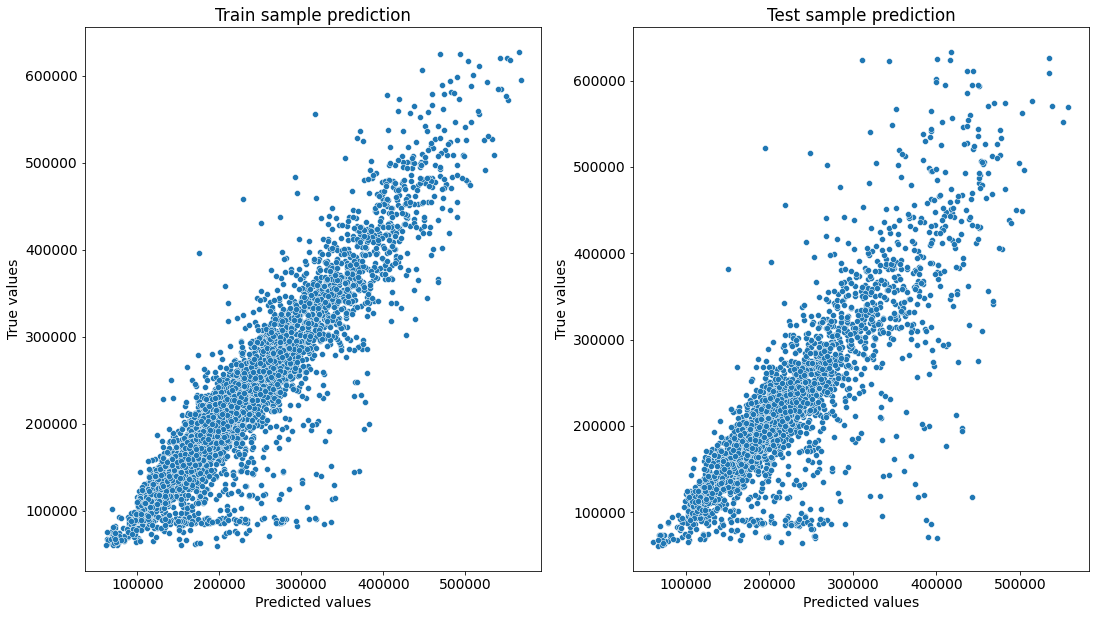

In [71]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### Кросс-валидация

In [72]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.70756919, 0.74654202, 0.73207828])

In [73]:
cv_score.mean()

0.7287298312053884

### Важность признаков

In [74]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
1,Square,0.454285
22,DistrictSize,0.265419
12,Social_3,0.058411
7,Ecology_1,0.032743
11,Social_2,0.025142
10,Social_1,0.020823
6,HouseYear,0.020373
0,Rooms,0.020236
5,HouseFloor,0.019025
25,MedPriceByFloorYear,0.018511


# Прогнозирование на тестовом датасете

In [75]:
test_df.shape

(5000, 26)

In [76]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize,new_district,IsDistrictLarge,MedPriceByFloorYear
0,1.0,36.847630,19.094182,5.0,5,9.0,1970.0,0.036122,1,1,...,1,0,0,0,0,0,70.0,0,0,189522.812250
1,1.0,42.568133,42.493907,10.0,7,17.0,2017.0,0.072158,1,1,...,0,0,0,0,0,1,164.0,0,1,168802.622692
2,2.0,59.463678,47.463678,9.0,19,19.0,1977.0,0.211401,1,1,...,1,0,0,0,1,1,568.0,0,1,174687.566186
3,3.0,49.646030,33.893825,6.0,2,2.0,1965.0,0.014073,1,1,...,1,0,0,0,0,1,375.0,0,1,179651.003718
4,1.0,53.837056,47.837056,3.0,8,17.0,1977.0,0.309479,1,1,...,1,0,0,0,1,0,76.0,0,0,192302.751941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,2,5.0,1962.0,0.069660,1,1,...,1,0,1,0,0,1,59.0,0,0,179651.003718
4996,3.0,94.521465,93.698122,10.0,21,27.0,2018.0,0.060753,1,1,...,1,0,0,0,0,0,25.0,0,0,212894.547600
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966.0,0.038693,1,1,...,1,0,0,0,0,0,69.0,0,0,179651.003718
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970.0,0.089040,1,1,...,1,0,0,0,0,1,35.0,0,0,192302.751941


In [77]:
submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [78]:
predictions = gb_model.predict(test_df)
predictions

array([162487.5979012 , 123107.38675042, 152843.16201418, ...,
       144146.97251118, 197077.21781455, 251355.78260133])

In [79]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,162487.597901
1,5925,123107.386750
2,960,152843.162014
3,3848,115898.532424
4,746,203625.257118


In [80]:
submit.to_csv('gb_submit.csv', index=False)